In [61]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve
from sklearn.metrics import  recall_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Plotting the graphs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['WA_Fn-UseC_-Telco-Customer-Churn.csv']


> **Data**

In [62]:
#Importing data
lowafilepath = '../input/WA_Fn-UseC_-Telco-Customer-Churn.csv'
data = pd.read_csv(lowafilepath)

In [63]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [64]:
print ("Rows     : " ,data.shape[0])
print ("Columns  : " ,data.shape[1])
print ("\nFeatures : \n" ,data.columns.tolist())
print("\nData Information : \n",data.info())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null

Column TotalCharges is having some missing values

> **Missing Value Removal**

In [65]:
# Removing the missing values
data = data[pd.notnull(data['TotalCharges'])]
print("Number of null values in total charges:",data['TotalCharges'].isna().sum())
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')

Number of null values in total charges: 0


> **EDA**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning:

invalid value encountered in greater

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning:

invalid value encountered in less



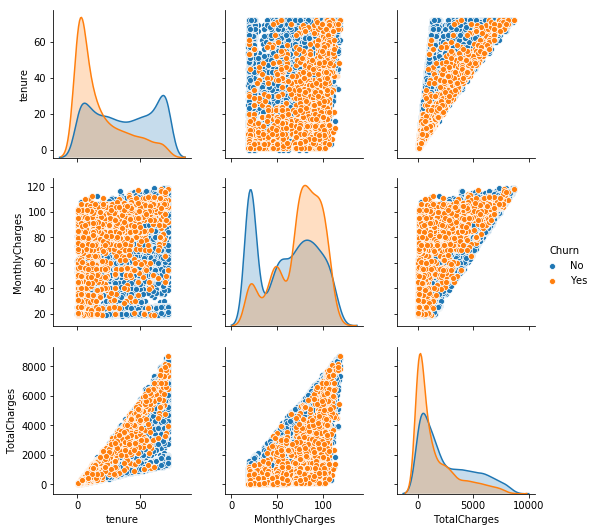

In [66]:
sns.pairplot(data,vars = ['tenure','MonthlyCharges','TotalCharges'], hue="Churn")

People having lower tenure and higher monthly charges are tend to churn more.

In [67]:
# Getting the categorical variables 
all_cat_var = data.nunique()[data.nunique()<5].keys().tolist()

# Getting the categorical variables without churn
cat_var = all_cat_var[:-1]

In [68]:
def pie_plot(Column):    
    ct1 = pd.crosstab(data[Column],data['Churn'])
    trace1 = go.Pie(labels = ct1.index,
                    values = ct1.iloc[:,0],
                    hole=0.3,
                    domain=dict(x=[0,.45]))
    trace2 = go.Pie(labels = ct1.index,
                    values = ct1.iloc[:,1],
                    domain=dict(x=[.55,1]),
                    hole=0.3)

    layout = go.Layout(dict(title = Column + " distribution in customer attrition ",
                                plot_bgcolor  = "rgb(243,243,243)",
                                paper_bgcolor = "rgb(243,243,243)",
                                annotations = [dict(text = "churn customers",
                                                    font = dict(size = 13),
                                                    showarrow = False,
                                                    x = .15, y = 1),
                                               dict(text = "Non churn customers",
                                                    font = dict(size = 13),
                                                    showarrow = False,
                                                    x = .88,y = 1)

                                              ]
                               )
                          )

    fig = go.Figure(data=[trace1,trace2],layout=layout)
    py.iplot(fig)

In [69]:
for i in cat_var:
    pie_plot(i)

In [70]:
# Removing the customer id
del data['customerID'] #customerID is a uninque id so it dosn't give any information

> **Statistical Test**

**Chi-square Test for Feature Extraction:**
Chi-square test is used for categorical features in a dataset. We calculate Chi-square between each feature and the target and select the desired number of features with best Chi-square scores.It determines if the association between two categorical variables of the sample would reflect their real association in the population.

In [71]:
# chi square test 

i = 0
for nam in cat_var:
    crosstab = pd.crosstab(data[nam], data['Churn'])
#     crosstab
    chi = stats.chi2_contingency(crosstab)
    if chi[1]<0.05:
        i=i+1
        print(i,nam, " is important for predicting churn with p value: ",chi[1] )

1 SeniorCitizen  is important for predicting churn with p value:  1.510066805092378e-36
2 Partner  is important for predicting churn with p value:  2.1399113440759935e-36
3 Dependents  is important for predicting churn with p value:  4.9249216612154196e-43
4 MultipleLines  is important for predicting churn with p value:  0.0034643829548773
5 InternetService  is important for predicting churn with p value:  9.571788222840544e-160
6 OnlineSecurity  is important for predicting churn with p value:  2.661149635176552e-185
7 OnlineBackup  is important for predicting churn with p value:  2.0797592160864276e-131
8 DeviceProtection  is important for predicting churn with p value:  5.505219496457244e-122
9 TechSupport  is important for predicting churn with p value:  1.4430840279998987e-180
10 StreamingTV  is important for predicting churn with p value:  5.528994485739183e-82
11 StreamingMovies  is important for predicting churn with p value:  2.667756755723681e-82
12 Contract  is important for 

Columns such as Gender and PhoneService are not important in predicting the churn

> **Label Encoding**

Label encodingrefers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.

In [72]:
le = LabelEncoder()

# apply "le.fit_transform"
data_new = data.apply(le.fit_transform)

Finding out the Multicollinearity using VIF

In [73]:
X = add_constant(data_new)
pd.Series([variance_inflation_factor(X.values, i) 
           for i in range(X.shape[1])], index=X.columns)

const               23.457307
gender               1.001769
SeniorCitizen        1.152390
Partner              1.462946
Dependents           1.384168
tenure              11.174077
PhoneService         1.605461
MultipleLines        1.411052
InternetService      1.755824
OnlineSecurity       1.263711
OnlineBackup         1.198035
DeviceProtection     1.291560
TechSupport          1.319403
StreamingTV          1.462937
StreamingMovies      1.460428
Contract             2.536214
PaperlessBilling     1.205989
PaymentMethod        1.180357
MonthlyCharges       5.270483
TotalCharges        15.276918
Churn                1.417730
dtype: float64

Total charges and tenure is having high VIF score which means multicoliniarity

In [74]:
# Splitiing to x and y

X = (data_new.loc[:, data_new.columns != 'Churn'])
y = (data_new.loc[:, data_new.columns == 'Churn'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns

Shape of X: (7043, 19)
Shape of y: (7043, 1)


> ** Base Model-Logistic Regression**

In [75]:
# Logistic regression Model

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#  Model metrics
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.79
[[929 112]
 [189 179]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1041
           1       0.62      0.49      0.54       368

   micro avg       0.79      0.79      0.79      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



> **Feature selection**

In [76]:
# Removing unimportant features ['gender','PhoneService','TotalCharges','tenure']
X_train.drop(['gender','PhoneService','TotalCharges','tenure'], axis=1, inplace=True)
X_test.drop(['gender','PhoneService','TotalCharges','tenure'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [77]:
# New model
logreg_new = LogisticRegression()
logreg_new.fit(X_train, y_train)

#  Model metrics
y_pred = logreg_new.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_new.score(X_test, y_test)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.77
[[918 123]
 [202 166]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1041
           1       0.57      0.45      0.51       368

   micro avg       0.77      0.77      0.77      1409
   macro avg       0.70      0.67      0.68      1409
weighted avg       0.76      0.77      0.76      1409



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [78]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Report : ",  classification_report(y_test, y_pred)) 

Accuracy: 0.7764371894960965
Report :                precision    recall  f1-score   support

           0       0.84      0.85      0.85      1041
           1       0.57      0.55      0.56       368

   micro avg       0.78      0.78      0.78      1409
   macro avg       0.71      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409

